In [1]:
import warnings
import pandas as pd
import numpy as np
import nltk
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import random
# import os
# import re
# import math
# from sqlalchemy import create_engine
# import pymysql
# import requests
# from bs4 import BeautifulSoup
# from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.ar_model import AR
# from statsmodels.tools.eval_measures import rmse
# from scipy import stats

In [2]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./clean_data/clean_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

### Step 1: transform dataset:
- each cocktail = one row
- all ingredients generalized and combined in one column

In [4]:
# Add non-alcoholic ingredients in a separate column

df['non_alc_ingredients'] = np.where(~df['Basic_taste'].isnull(), df['strIngredients'], np.nan)

In [5]:
# Reduce dataset to only the columns required for current step

df_ingredients = df[['strDrink', 'Alc_type', 'non_alc_ingredients', 'Garnish_type']]

In [6]:
# Drop rows with garnish, this part of the cocktail will be processed on the later stages

df_ingredients.drop(df_ingredients.loc[~df_ingredients['Garnish_type'].isnull()].index, axis=0, inplace=True)

In [7]:
'''
Drop punches to avoid missing errors during 'measures' part
'''

"\nDrop punches to avoid missing errors during 'measures' part\n"

In [8]:
# Replace nan values with empty string to align data type for every value

df_ingredients.fillna('', inplace=True)

In [9]:
# Replace ' ' with '_' to keep adjectives with nouns

df_ingredients['Alc_type'] = df_ingredients['Alc_type'].apply(lambda x: x.replace(' ', '_'))
df_ingredients['non_alc_ingredients'] = df_ingredients['non_alc_ingredients'].apply(lambda x: x.replace(' ', '_'))

In [10]:
# Reallocate ingredients as columns so each column takes only one row

df_ingredients = df_ingredients[df_ingredients['Alc_type'] != 'Alc_type']
s =  df_ingredients.groupby('strDrink').cumcount().add(1)
df_ingredients = (df_ingredients.set_index(['strDrink',s])
        .unstack()
        .sort_index(axis=1, level=1)
       )
df_ingredients.columns = ['{}_{}'.format(a, b) for a,b in df_ingredients.columns]

df_ingredients = df_ingredients.reset_index()
df_ingredients.head()

,strDrink,Alc_type_1,Garnish_type_1,non_alc_ingredients_1,Alc_type_2,Garnish_type_2,non_alc_ingredients_2,Alc_type_3,Garnish_type_3,non_alc_ingredients_3,Alc_type_4,Garnish_type_4,non_alc_ingredients_4,Alc_type_5,Garnish_type_5,non_alc_ingredients_5,Alc_type_6,Garnish_type_6,non_alc_ingredients_6,Alc_type_7,Garnish_type_7,non_alc_ingredients_7,Alc_type_8,Garnish_type_8,non_alc_ingredients_8,Alc_type_9,Garnish_type_9,non_alc_ingredients_9,Alc_type_10,Garnish_type_10,non_alc_ingredients_10
0,'57 Chevy with a White License Plate,Creamy_Liqueur,,,Vodka,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-900-FUK-MEUP,Vodka,,,Triple_Sec,,,Sweet_Liqueur,,,Sweet_Liqueur,,,Rum,,,Sweet_Liqueur,,,,,Cranberry_Juice,,,Pineapple_Juice,NaN,NaN,NaN,NaN,NaN,NaN
2,110 in the shade,Beer,,,Tequila,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,151 Florida Bushwacker,Rum,,,Rum,,,Rum,,,Creamy_Liqueur,,,Triple_Sec,,,,,Milk,Sweet_Liqueur,,,,,Vanilla_Ice-Cream,NaN,NaN,NaN,NaN,NaN,NaN
4,155 Belmont,Rum,,,Rum,,,Vodka,,,,,Orange_Juice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_ingredients['Ingredients'] = df_ingredients.drop(['strDrink'], axis=1).fillna('').apply(lambda x:
                                                                          ' '.join(x), axis=1).apply(lambda x: x.lower())
df_ingredients = df_ingredients[['strDrink', 'Ingredients']]

In [12]:
df_ingredients.head()

,strDrink,Ingredients
0,'57 Chevy with a White License Plate,creamy_liqueur vodka
1,1-900-FUK-MEUP,vodka triple_sec sweet_liqueur sweet_liq...
2,110 in the shade,beer tequila
3,151 Florida Bushwacker,rum rum rum creamy_liqueur triple_sec ...
4,155 Belmont,rum rum vodka orange_juice ...


### Step 2:
- split ingerients by pairs
- compute most common pairs (N - to be defined depending on results)

In [13]:
# Generate pairs from ingredients of each cocktail and combine them in one list

bigram = [list(nltk.bigrams(nltk.word_tokenize(i))) for i in df_ingredients['Ingredients']]
pairs_list = [j for i in bigram for j in i]
print(len(pairs_list))
pairs_list[:10]

1185


[('creamy_liqueur', 'vodka'),
 ('vodka', 'triple_sec'),
 ('triple_sec', 'sweet_liqueur'),
 ('sweet_liqueur', 'sweet_liqueur'),
 ('sweet_liqueur', 'rum'),
 ('rum', 'sweet_liqueur'),
 ('sweet_liqueur', 'cranberry_juice'),
 ('cranberry_juice', 'pineapple_juice'),
 ('beer', 'tequila'),
 ('rum', 'rum')]

There are some tuples where elements are swopped but essential taste of such combination is not unique. Such tuples need to be alighned.

In [14]:
# First, define a list of tuples to be amended

to_aligh = []
for a in pairs_list:
    for b in pairs_list:
        if a != b:
            if b[1] == a[0]:
                if b[0] == a[1]:            # If both elements of tuple are equal to the swopped tuple under the check
                    if a not in to_aligh and b not in to_aligh:
                        to_aligh.append(b)

In [15]:
# Second, amend them

pairs_list_aligned = []
for i in pairs_list:
    if i in to_aligh:
        pairs_list_aligned.append((i[1], i[0]))
    else:
        pairs_list_aligned.append(i)

In [16]:
# Check that total number of tuples hasn't changed, only content should be amended

len(pairs_list_aligned) == len(pairs_list)

True

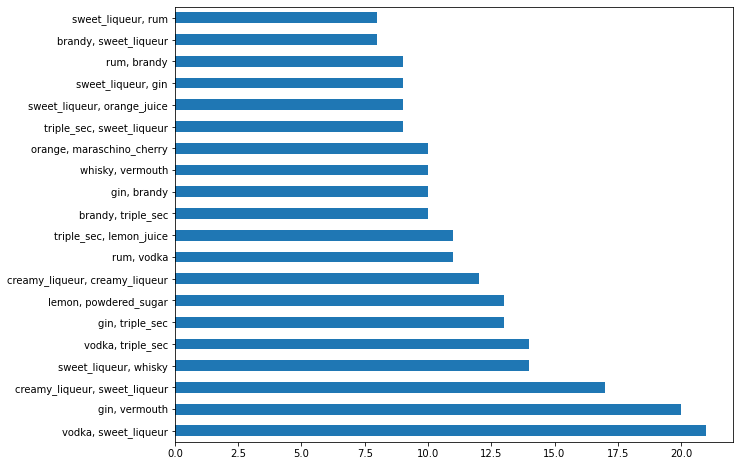

In [17]:
# Plot the most common pairs

pairs_list_flat = [(i[0]+', '+i[1]) for i in pairs_list_aligned]
pairs = pd.DataFrame(pairs_list_flat, columns=['pairs'])
plt.figure(figsize = (10,8))
ax = pairs['pairs'].value_counts().nlargest(20).plot.barh()
plt.show()

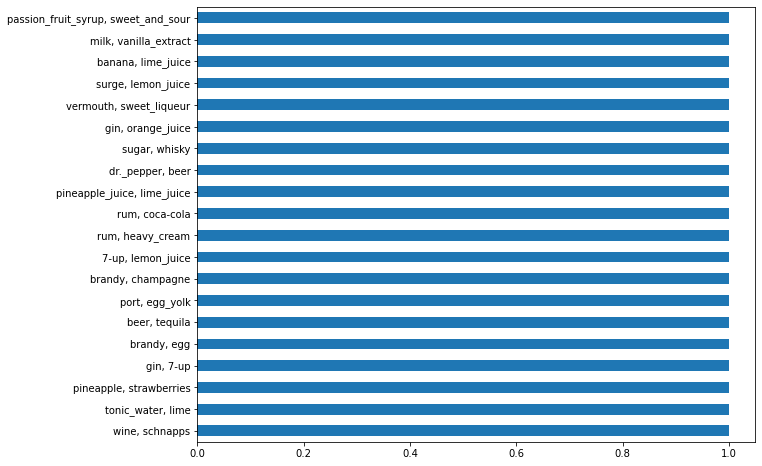

In [18]:
# Plot the least common pairs

plt.figure(figsize = (10,8))
ax = pairs['pairs'].value_counts().nsmallest(20).plot.barh()
plt.show()

In [19]:
# Define 25% of the most common pairs as a separate list

counter=collections.Counter(pairs_list_aligned)
print(len(counter))
common_pairs = counter.most_common(int(len(counter)*0.25))
common_pairs

580


[(('vodka', 'sweet_liqueur'), 21),
 (('gin', 'vermouth'), 20),
 (('creamy_liqueur', 'sweet_liqueur'), 17),
 (('vodka', 'triple_sec'), 14),
 (('sweet_liqueur', 'whisky'), 14),
 (('gin', 'triple_sec'), 13),
 (('lemon', 'powdered_sugar'), 13),
 (('creamy_liqueur', 'creamy_liqueur'), 12),
 (('rum', 'vodka'), 11),
 (('triple_sec', 'lemon_juice'), 11),
 (('gin', 'brandy'), 10),
 (('whisky', 'vermouth'), 10),
 (('brandy', 'triple_sec'), 10),
 (('orange', 'maraschino_cherry'), 10),
 (('triple_sec', 'sweet_liqueur'), 9),
 (('sweet_liqueur', 'orange_juice'), 9),
 (('sweet_liqueur', 'gin'), 9),
 (('rum', 'brandy'), 9),
 (('sweet_liqueur', 'rum'), 8),
 (('brandy', 'sweet_liqueur'), 8),
 (('creamy_liqueur', 'vodka'), 7),
 (('rum', 'rum'), 7),
 (('orange_juice', 'grenadine'), 7),
 (('gin', 'bitter'), 7),
 (('sweet_liqueur', 'bitter'), 7),
 (('triple_sec', 'lime_juice'), 7),
 (('gin', 'lemon_juice'), 7),
 (('rum', 'beer'), 7),
 (('whisky', 'lemon'), 7),
 (('lemon_juice', 'sugar_superfine'), 7),
 (('s

In [20]:
common_ingredients = []

for n in common_pairs:
    common_ingredients.append(n[0][0])
    common_ingredients.append(n[0][1])
common_ingredients = list(set(common_ingredients))
common_ingredients

['vodka',
 'lemon',
 'carbonated_water',
 'campari',
 'coca-cola',
 'soda_water',
 'tonic_water',
 'gin',
 'bitter',
 'grenadine',
 'tequila',
 'beer',
 'creamy_liqueur',
 'lemonade',
 'lemon_peel',
 'powdered_sugar',
 'wine',
 'lemon_juice',
 'egg',
 'triple_sec',
 'sugar_syrup',
 'club_soda',
 'brandy',
 'cider',
 'vermouth',
 'sugar_superfine',
 'champagne',
 'sugar',
 'coffee',
 'sweet_and_sour',
 'whisky',
 'ginger_beer',
 'orange',
 'cranberry_juice',
 'rum',
 'egg_white',
 'orange_juice',
 'water',
 'light_cream',
 'milk',
 'pineapple_juice',
 'sweet_liqueur',
 'maraschino_cherry',
 'lime_juice',
 'vanilla_ice-cream',
 'schnapps',
 'sour_mix',
 'lime',
 'sambuca']

### Step 3: generate a frame for new combinations:
- define total number of ingerients (random choice from a range 3-6))
- from ingredients included in top pairs pick one randomly
- find suitable pair for this ingredient (from all pairs, but give top pairs bigger weight)
- do the same for the next ingredient but check that it's not included already
- etc until limit is reached

In [21]:
# Define total number of ingredients for a new cocktail

n_ingr = random.randint(3,7)

In [22]:
new_cocktail = []

In [23]:
# Pick the first ingredient randomly from the top popular

first_ingr = random.choice(common_ingredients)
new_cocktail.append(first_ingr)

In [24]:
# Identify remaning ingredients

counter = 1          # Not zero because the first ingredient is defined separatelly above
while counter < n_ingr:
    temp_list = []
    for i in set(pairs_list_aligned):
        if new_cocktail[-1] in i:
            temp_list.append(i)
    random_pair = random.choice(temp_list)
    if random_pair[0] == new_cocktail[-1]:
        next_ingr = random_pair[1]
    else:
        next_ingr = random_pair[0]
    new_cocktail.append(next_ingr)
    counter += 1

In [25]:
new_cocktail

['milk', 'sugar', 'lime_juice', 'gin', 'water', 'wine']

### Step 4: define volume of each ingredient

In [26]:
# Create new dataframe with relevant columns only

df_measures = df[['strDrink', 'strCategory', 'Alc_type', 'non_alc_ingredients', 'Value_ml', 'Value_gr']]

In [27]:
df_measures.loc[df_measures['non_alc_ingredients'] == 'Pepsi Cola']

,strDrink,strCategory,Alc_type,non_alc_ingredients,Value_ml,Value_gr
1213,Mudslinger,Punch / Party Drink,NaN,Pepsi Cola,750.0,NaN
1282,Smut,Punch / Party Drink,NaN,Pepsi Cola,10.0,NaN


In [28]:
# Remove cocktails given in big volumes to align scale

df_measures.drop(df_measures.loc[df_measures['strCategory'].str.contains('Punch')].index, axis=0, inplace=True)

In [29]:
# Combine values in one column and define measure for each in a separate column

df_measures['Measure'] = np.where(df_measures['Value_ml'].isnull(), 'gr', 'ml')
df_measures['Value'] = df_measures['Value_ml'].fillna(0) + df_measures['Value_gr'].fillna(0)
df_measures['Ingredients'] = df_measures['Alc_type'].fillna('') + df_measures['non_alc_ingredients'].fillna('')
df_measures['Ingredients'] = df_measures['Ingredients'].apply(lambda x: x.lower()).apply(lambda x: x.replace(' ', '_'))
df_measures.head()

,strDrink,strCategory,Alc_type,non_alc_ingredients,Value_ml,Value_gr,Measure,Value,Ingredients
0,'57 Chevy with a White License Plate,Cocktail,Creamy Liqueur,NaN,30.0,NaN,ml,30.0,creamy_liqueur
1,1-900-FUK-MEUP,Shot,Vodka,NaN,15.0,NaN,ml,15.0,vodka
2,110 in the shade,Beer,Beer,NaN,480.0,NaN,ml,480.0,beer
3,151 Florida Bushwacker,Milk / Float / Shake,Rum,NaN,15.0,NaN,ml,15.0,rum
4,155 Belmont,Cocktail,Rum,NaN,25.0,NaN,ml,25.0,rum


In [30]:
# Combine value and measure in one string, this way it will be easier to pick up random value together with correct measure

df_measures['Value'] = df_measures['Value'].astype('object').apply(lambda x: str(x))
df_measures['Value_Measure'] = df_measures[['Value', 'Measure']].apply(lambda x: ' '.join(x), axis=1)
df_measures.head()

,strDrink,strCategory,Alc_type,non_alc_ingredients,Value_ml,Value_gr,Measure,Value,Ingredients,Value_Measure
0,'57 Chevy with a White License Plate,Cocktail,Creamy Liqueur,NaN,30.0,NaN,ml,30.0,creamy_liqueur,30.0 ml
1,1-900-FUK-MEUP,Shot,Vodka,NaN,15.0,NaN,ml,15.0,vodka,15.0 ml
2,110 in the shade,Beer,Beer,NaN,480.0,NaN,ml,480.0,beer,480.0 ml
3,151 Florida Bushwacker,Milk / Float / Shake,Rum,NaN,15.0,NaN,ml,15.0,rum,15.0 ml
4,155 Belmont,Cocktail,Rum,NaN,25.0,NaN,ml,25.0,rum,25.0 ml


In [31]:
# Pick up random volume of each ingredient

for i in new_cocktail:
    volume = [random.choice(df_measures.loc[df_measures['Ingredients'] == i]['Value_Measure'].tolist()) for i in new_cocktail]
    new_cocktail_final = pd.DataFrame({'Ingredient': new_cocktail, 'Volume': volume})
    new_cocktail_final

### Step 5: define garnish

***1) Prepare list of main ingredients with garnish for each cocktail in dataset***

In [32]:
# Define reduced dataframe which contains only relevant fields

df_garnish = df[['strDrink', 'strIngredients', 'Alc_type', 'Value_ml', 'Garnish_amount', 'Garnish_type']]

In [33]:
df_garnish['Ingredients'] = np.where(df_garnish['Alc_type'].isnull(), df_garnish['strIngredients'], df_garnish['Alc_type'])

In [34]:
# Combine value and measure of garnish in one column so it will be easier to pick it up later in the code

df_garnish['Garnish_ingr'] = np.where(~df_garnish['Garnish_amount'].isnull(), df_garnish['strIngredients'], np.nan)
df_garnish['Garnish'] = df_garnish[['Garnish_ingr', 'Garnish_amount', 'Garnish_type']].fillna('').apply(lambda x:
                                                                                                       ' '.join(x), axis=1)
df_garnish['Garnish'] = df_garnish['Garnish'].apply(lambda x: x.replace('0 top', 'top'))
df_garnish['Garnish'] = np.where(df_garnish['Garnish'] == '  ', np.nan, df_garnish['Garnish'])

In [35]:
# Rearrange dataframe that way that it's possible to identify garnish per cocktail per dominant ingredient

drink_name_list = []
garnish_list = []
ingredient_list = []

for drink in df_garnish['strDrink'].unique():      # For each cocktial
    df_selected = df_garnish.loc[df_garnish['strDrink'] == drink]
    max_value = df_selected['Value_ml'].max()

    for ingr in df_selected.loc[df_selected['Value_ml'] == max_value]['Ingredients']:
        for garnish in df_selected['Garnish'].unique():
            drink_name_list.append(drink)
            garnish_list.append(garnish)           # Include all garnishes for the drink
            ingredient_list.append(ingr)           # Include an ingredient taking the biggest part of the drink

df_garnish_final = pd.DataFrame({'Drink':drink_name_list, 'Ingredient':ingredient_list, 'Garnish':garnish_list})
df_garnish_final.drop(df_garnish_final.loc[df_garnish_final['Garnish'].isnull()].index, axis=0, inplace = True)

In [36]:
df_garnish_final.head()

,Drink,Ingredient,Garnish
17,3-Mile Long Island Iced Tea,Coca-Cola,Lemon 1 wedge
20,50/50,Vodka,Orange Juice top up
28,A Furlong Too Late,Ginger Beer,Lemon Peel 1 twist
32,A Night In Old Mandalay,Beer,Lemon Peel 1 twist
41,A.D.M. (After Dinner Mint),Whisky,Hot Chocolate top up


***2) Identify a main ingredient of a generated cocktail***

In [37]:
new_cocktail_final

,Ingredient,Volume
0,milk,0.0 gr
1,sugar,30.0 ml
2,lime_juice,45.0 ml
3,gin,0.0 gr
4,water,4.0 gr
5,wine,0.0 gr


In [38]:
new_cocktail_final = new_cocktail_final.join(new_cocktail_final['Volume'].str.rsplit(n=1, expand=True).rename(columns={
                                                                                                    0: 'Value', 1: 'Measure'}))
new_cocktail_final['Value'] = new_cocktail_final['Value'].astype('float')

In [39]:
main_ingr = random.choice(new_cocktail_final.loc[new_cocktail_final['Value'] ==
                                                                     new_cocktail_final['Value'].max()]['Ingredient'].tolist())

In [40]:
new_cocktail_final.drop(['Value', 'Measure'], axis=1, inplace=True)

***3) Find suitable garnish and add to the recipe***

In [41]:
garnish_to_add = df_garnish_final.loc[df_garnish_final['Ingredient'] == main_ingr]['Garnish'].tolist()

if garnish_to_add:
    new_cocktail_final.loc[len(new_cocktail_final)] = ['garnish', garnish_to_add]

In [42]:
new_cocktail_final

,Ingredient,Volume
0,milk,0.0 gr
1,sugar,30.0 ml
2,lime_juice,45.0 ml
3,gin,0.0 gr
4,water,4.0 gr
5,wine,0.0 gr


In [43]:
# Refactoring might be done to rearrange the code that way that to generate new cocktail you don't have to run whole file

### List alcoholic ingredients

In [44]:
df.head()

,strDrink,strCategory,strGlass,strIngredients,Alc_type,Basic_taste,strInstructions,strMeasures,Value,MeasureName,Value_numeric,Value_ml,Value_gr,Garnish_amount,Garnish_type,MeasureName_copy,non_alc_ingredients
0,'57 Chevy with a White License Plate,Cocktail,Highball glass,Creme De Cacao White,Creamy Liqueur,NaN,1. Fill a rocks glass with ice 2.add white cre...,1 oz white,1,oz,1.0,30.0,NaN,NaN,NaN,white,NaN
1,1-900-FUK-MEUP,Shot,Old-fashioned glass,Absolut Kurant,Vodka,NaN,Shake ingredients in a mixing tin filled with ...,1/2 oz,1/2,oz,0.5,15.0,NaN,NaN,NaN,oz,NaN
2,110 in the shade,Beer,Beer Glass,Lager,Beer,NaN,Drop shooter in glass. Fill with beer,16 oz,16,oz,16.0,480.0,NaN,NaN,NaN,oz,NaN
3,151 Florida Bushwacker,Milk / Float / Shake,Beer mug,Malibu Rum,Rum,NaN,Combine all ingredients. Blend until smooth. G...,1/2 oz,1/2,oz,0.5,15.0,NaN,NaN,NaN,oz,NaN
4,155 Belmont,Cocktail,White wine glass,Dark Rum,Rum,NaN,Blend with ice. Serve in a wine glass. Garnish...,1 shot,1,shot,1.0,25.0,NaN,NaN,NaN,shot,NaN


In [45]:
df['Alc_type'].unique()

array(['Creamy Liqueur', 'Vodka', 'Beer', 'Rum', 'Schnapps', 'Whisky',
       'Gin', 'Triple Sec', 'Sweet Liqueur', nan, 'Brandy', 'Vermouth',
       'Bitter', 'Campari', 'Cider', 'Tequila', 'Champagne', 'Sambuca',
       'Wine', 'Pisco', 'Cachaca', 'Absinthe', 'Port', 'Prosecco', 'Ouzo',
       'Aperol'], dtype=object)

In [46]:
for i in df['Alc_type'].unique():
    print(i)
    print(df.loc[df['Alc_type'] == i]['strIngredients'].unique())
    print('*'*100)

Creamy Liqueur
['Creme De Cacao White' 'Kahlua' "Bailey'S Irish Cream" 'Irish Cream'
 'Chocolate Liqueur' 'Baileys Irish Cream' 'Advocaat' 'Godiva Liqueur'
 'Creme De Cacao' 'Dark Creme De Cacao' 'Tia Maria' 'Creme De Mure']
****************************************************************************************************
Vodka
['Absolut Kurant' 'Peach Vodka' 'Vanilla Vodka' 'Absolut Citron' 'Vodka'
 'Absolut Vodka' 'Lemon Vodka' 'Vodka Smirnoff' 'Everclear' 'Firewater'
 'Cranberry Vodka' 'Raspberry Vodka' 'Vodka Smirnoff Red Label'
 'Absolut Peppar' 'Grain Alcohol' 'Lime Vodka' 'Aquavit']
****************************************************************************************************
Beer
['Lager' 'Ale' 'Guinness Stout' 'Corona' 'Beer' 'Zima' 'Ginger Ale']
****************************************************************************************************
Rum
['Malibu Rum' 'Dark Rum' '151 Proof Rum' 'Coconut Rum' 'Light Rum' 'Rum'
 'Añejo Rum' 'Bacardi Limon' 'Spiced Rum' '151 P

In [47]:
for i in new_cocktail:
    random.choice(df.loc[df['Alc_type'] == i]['strIngredients'].unique().tolist())

IndexError: Cannot choose from an empty sequence

In [ ]:
new_cocktail_final

In [ ]:
df.loc[df['strIngredients'].str.contains('Tonic')]

In [ ]:
# Try to set up lists of liqueurs and maybe other alcohol ingredients.